In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("../..")


import neuroprob as mdl
from neuroprob import utils

import utils_func

dev = utils.pytorch.get_device()

PyTorch version: 1.7.1+cu101
Using device: cuda:0


This notebook contains classical analysis of linear track data.

### Loading data

In [3]:
# data
data_path = "../data/th1/"
session_name = 'ec014.468'
max_ISI_order = 4

select_fracs = [0.0, 0.1]
dataset_dict = th1.spikes_dataset(session_name, data_path, max_ISI_order, select_fracs)

test_select_fracs = [0.1, 0.2]
test_dataset_dict = th1.spikes_dataset(session_name, data_path, max_ISI_order, test_select_fracs)

### Separate runs: L-R, R-L, stationary

In [9]:
c_x_t = utils_func.class_x_t(x_t)
dir_t = utils_func.L_R_run(c_x_t)
ind_L_R = np.where(dir_t == -1)
ind_R_L = np.where(dir_t == 1)
ind_stat = np.where(dir_t == 0)
print("% L_R ind: {}%".format(len(ind_L_R[0]) / len(dir_t)*100))
print("% R_L ind: {}%".format(len(ind_R_L[0]) / len(dir_t)*100))
print("% end/stationary ind: {}%".format(len(ind_stat[0]) / len(dir_t)*100))

# incompleted runs:  1
% L_R ind: 10.62406005172688%
% R_L ind: 13.714040059631877%
% end/stationary ind: 75.66189988864124%


### Select units

Select units by number of spikes and sparsity:

In [7]:
# binning of covariates and analysis
bins_x = 40
bins_y = int(arena_height/arena_width*bins_x)
bins_theta = 20

bin_x = np.linspace(left_x, right_x+1e-3, bins_x+1)
bin_y = np.linspace(bottom_y, top_y+1e-3, bins_y+1)
bin_theta = np.linspace(0, 2*np.pi+1e-3, bins_theta+1)

#corr_t_spikes = utils.neural.spike_threshold(sample_bin, 0.25, (x_t, y_t), (bin_x, bin_y), sep_t_spike)
# selection of bins > 0.25 already happens in IPP_model here for convenience
# Mutual Informations
sp_rate, sp_prob = utils.neural.IPP_model(sample_bin, 0.25, (x_t, y_t), (bin_x, bin_y), 
                                          sep_t_spike, divide=True)
sp_MI  = utils.neural.spike_var_MI(sp_rate, sp_prob)

sm_size = 5
sm_filter = np.ones((sm_size, sm_size)) / sm_size**2
smth_rate = utils.neural.smooth_hist(sp_rate, sm_filter, ['repeat', 'repeat'], dev='cpu')
coherence, sparsity = utils.neural.geometric_tuning(sp_rate, smth_rate, sp_prob) # coherence and sparsity of fields

In [10]:
n_spikes_L_R = np.sum(spktrain[:, ind_L_R], axis=(1, 2), dtype=int)
n_spikes_R_L = np.sum(spktrain[:, ind_R_L], axis=(1, 2), dtype=int)
n_spikes_stat = np.sum(spktrain[:, ind_stat], axis=(1, 2), dtype=int)

In [11]:
unit_discard = np.intersect1d(np.where(n_spikes_L_R < 200), np.where(n_spikes_R_L < 200))
print("# discarded units (< 200 spikes): ", len(unit_discard))
print(unit_discard)
unit_used = np.union1d(np.where(n_spikes_L_R > 200), np.where(n_spikes_R_L > 200))
print("Units left: ", len(unit_used))

# discarded units (< 200 spikes):  39
[ 2  6  7 13 15 16 17 18 19 22 23 27 29 30 32 40 45 46 47 48 49 50 52 54
 58 60 61 62 65 67 72 73 74 75 78 80 81 82 90]
Units left:  57


In [12]:
# Discard neurons if not sparse, enough (inhibitory neurons always ON)
unit_used = np.intersect1d(unit_used, np.argsort(sparsity)[18:])
print("Units left: ", len(unit_used))

Units left:  39


### Fit 2D GP

In [18]:
def heatmap_GP(rate_model, xlim, unit_used, xtheta_rate=None, eval_type='mean'):
    # run_type: 0 for L_R, 1 for R_L
    
    def make_func(neuron):
        def func_GP(pos):
            prevshape = pos.shape[1:]
            x = pos[0].flatten()
            theta = pos[1].flatten()
            covariates = [x, theta]
            lower, mean, upper = rate_model.eval_rate(covariates, [neuron], 'posterior')
            if eval_type == 'mean':
                return mean[0].reshape(*prevshape)
            elif eval_type == 'lower':
                return lower[0].reshape(*prevshape)
            elif eval_type == 'upper':
                return upper[0].reshape(*prevshape)
                
        return func_GP
    
    nrows = rate_model.out_dims
    ncols = 2 if xtheta_rate is not None else 1
    widths = [0.5] * ncols
    heights = [1] * nrows
    
    fig = plt.figure(figsize=(4*ncols, 3*nrows))

    spec = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths,
                             height_ratios=heights)#, left=0., right=0.2, bottom=0., top=1.)
    
    for neuron in range(rate_model.out_dims):
        if xtheta_rate is not None:
            grid_shape = [xlim, [0, 4*np.pi]]
            
            ax = fig.add_subplot(spec[neuron, 1])
            field = np.tile(xtheta_rate[neuron].T, (2,1)) # 0->0, 1->2 as 1 is stationary/end runs
            im = utils.plot.visualize_field((fig, ax), field, grid_shape, ticktitle='firing rate (Hz)', aspect='auto')

            ylabel = r'$\theta$'
            xlabel = r'$x$ (mm)'
            utils.plot.decorate_ax(ax, xlabel=xlabel, ylabel=ylabel, xlim=xlim, ylim=[0, 4*np.pi],
                                  xticks=np.linspace(xlim[0], xlim[1], 3), yticks=[0, 2*np.pi, 4*np.pi],
                                  spines=[False, False, False, False])
            ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])
            ax.set_title("Histogram Neuron {}".format(unit_used[neuron]))
            vmax = np.max(field)
            
        
        grid_shape = [xlim, [0, 4*np.pi]]
        grid_size = [40, 30]

        ax = fig.add_subplot(spec[neuron, 0])
        _, field = utils.plot.compute_mesh(grid_size, grid_shape, make_func(neuron))
        im = utils.plot.visualize_field((fig, ax), field, grid_shape, ticktitle='firing rate (Hz)', aspect='auto') #, vmax=vmax)

        ylabel = r'$\theta$'
        xlabel = r'$x$ (mm)'
        utils.plot.decorate_ax(ax, xlabel=xlabel, ylabel=ylabel, xlim=xlim, ylim=[0, 4*np.pi],
                          xticks=np.linspace(xlim[0], xlim[1], 3), yticks=[0, 2*np.pi, 4*np.pi],
                          spines=[False, False, False, False])
        ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])
        ax.set_title("GP Neuron {}".format(unit_used[neuron]))
            
    plt.tight_layout(w_pad=1)
    plt.show()
    
    return fig

In [17]:
print("spktrain: ", np.shape(spktrain))
print("x_t: ", np.shape(x_t))
print("theta_t: ", np.shape(theta_t))

spktrain:  (96, 4877928)
x_t:  (4877928,)
theta_t:  (4877928,)


In [25]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0) 
a = torch.cuda.memory_allocated(0)
f = t-(r-a)  # free inside reserved
# print("Total: ", t/1e9)
print("Reserved: ", r/1e9)
print("Allocated: ", a/1e9)
print("Free: ", f/1e9)

Reserved:  0.96468992
Allocated:  3.584e-05
Free:  3.330313216


In [ ]:
### evaluation ###
x_evals = 40
y_evals = 40
x_dims = 2

x_eval = jnp.linspace(0, 500, x_evals)
y_eval = jnp.linspace(0, 500, y_evals)
evalsteps = x_eval*y_eval

x_eval, y_eval = np.meshgrid(x_eval, y_eval)
or_shape = x_eval.shape

pos_eval = jnp.stack([x_eval, y_eval], axis=-1).reshape(-1, x_dims)
theta_eval = 0.0 * jnp.ones((pos_eval.shape[0], 1))

sp_locs = model.obs_model.gp.induc_locs
locs_eval = jnp.concatenate((pos_eval, theta_eval), axis=-1)[None, None, ...]


post_mean, post_cov, KL = model.obs_model._gp_posterior(
    locs_eval, mean_only=False, diag_cov=True, compute_KL=True, jitter=1e-8)

neurons = model.obs_model.likelihood.obs_dims

post_mean = post_mean[0].reshape(neurons, *or_shape)
post_var = post_cov[0].reshape(neurons, *or_shape)

link_fn = model.obs_model.likelihood.inverse_link

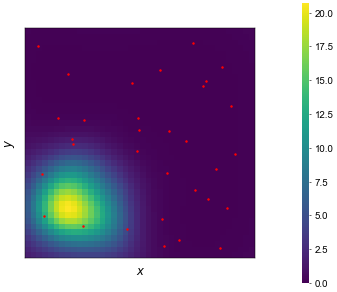

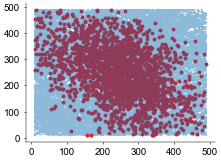

In [21]:
n = 1


fig = plt.figure(figsize=(8, 4))
widths = [1, 1, 0.03]
heights = [1]

spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, 
                        height_ratios=heights, top=1., bottom=0.0, 
                        left=0., right=1., wspace=0.3)

ax = fig.add_subplot(spec[0, 1])
lib.utils.plots.decorate_ax(ax)  # get all four spines around plot
ax.scatter(sp_locs[n, :, 0], sp_locs[n, :, 1], marker='.', c='r')
im = ax.imshow(link_fn(post_mean[n, ...]), 
           extent=[locs_eval[..., 0].min(), locs_eval[..., 0].max(), 
                   locs_eval[..., 1].min(), locs_eval[..., 1].max()], 
           aspect='equal', origin='lower', cmap='viridis', vmin=0.)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
#ax.set_title('noise correlations')


ax = fig.add_subplot(spec[0, 2])
lib.utils.plots.add_colorbar((fig, ax), im, cbar_outline=False, cbar_ori='vertical', cbar_fontsize=12, 
    cbar_pad=20, ticktitle=None, ticks=None, ticklabels=None, cbar_format=None)


# plt.scatter(sp_locs[n, :, 0], sp_locs[n, :, 1], marker='.', c='r')
# plt.imshow(post_var[n, ...], 
#            extent=[locs_eval[..., 0].min(), locs_eval[..., 0].max(), 
#                    locs_eval[..., 1].min(), locs_eval[..., 1].max()], 
#            aspect='equal', vmin=0., origin='lower', cmap='viridis')
# plt.show()

fig = plt.figure()
n = 0
plt.plot(x_t, y_t, alpha=0.5)
plt.scatter(x_t[spikes[n].astype(bool)], y_t[spikes[n].astype(bool)], c='r')
plt.show()

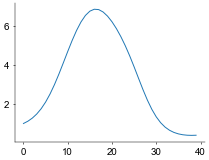

In [22]:
plt.plot(link_fn(post_mean)[n, 25, :])


f_dim = 0
x_dim = 0
tr = list(range(num_samps))

n_ps = qf_c.shape[-2]
#qf_v = qf_c[f_dim, tr, 0]
qf_v = qf_c[0, f_dim, np.arange(n_ps), np.arange(n_ps)]
lb = qf_m[0, f_dim, :, 0] - 1.96 * qf_v ** 0.5
ub = qf_m[0, f_dim, :, 0] + 1.96 * qf_v ** 0.5
m = qf_m[0, f_dim, :, 0]

x = xx[0, f_dim ,:, x_dim]

plt.plot(x, m, 'b', label='posterior mean')
plt.fill_between(x, lb, ub, color='b', alpha=0.05, label='95% confidence')#
plt.plot(x, qf_x[tr, f_dim, :].T, alpha=0.3)
plt.scatter(induc_locs[f_dim, :, x_dim], u_mu[f_dim, :, 0], marker='x', s=100)
plt.show()